In [1]:
import os
import time
import copy
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap, MDS, SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Function

from models import *
from utils import *
from datasets import *

In [2]:
from ppo import *
from env import *

In [5]:
class PointPrefDataset(Dataset):
    def __init__(self, names, path="./exp1/data_augmented/", one_hot=False):
        
        self.names = names

        self.point_data = []
        self.point_label = []
        for i in tqdm(range(len(names))):
            zi, yi = torch.load(os.path.join(path, self.names[i]))
            zi = get_Ihat(Z=normalise(zi), size=100)

            zi = torch.from_numpy(zi).unsqueeze(0).float()
            yi = torch.tensor(yi).long()

            self.point_data.append(zi)
            self.point_label.append(yi)

        self.point_data = torch.from_numpy(np.stack(self.point_data, axis=0))
        print(self.point_data.shape)
        
        if one_hot==True:
            self.point_label = F.one_hot(torch.tensor(self.point_label)-1, num_classes=5).float()
        else:
            self.point_label = torch.tensor(self.point_label)-1


    def __len__(self):
        return len(self.point_data)

    def __getitem__(self, idx):
        z = self.point_data[idx]
        label = self.point_label[idx]

        return z, label

names = os.listdir("./exp1/data_augmented/")
np.random.shuffle(names)
train_names = names[:int(len(names)*0.8)]
test_names = names[int(len(names)*0.8):]

point_dataset = PointPrefDataset(train_names, one_hot=True)
z, label = point_dataset[0]
print(z.shape, label)

point_testdataset = PointPrefDataset(test_names, one_hot=True)
z, label = point_testdataset[0]
print(z.shape, label)

print(len(point_dataset), len(point_testdataset))

100%|██████████| 6016/6016 [01:44<00:00, 57.37it/s]


torch.Size([6016, 1, 100, 100])
torch.Size([1, 100, 100]) tensor([1., 0., 0., 0., 0.])


100%|██████████| 1504/1504 [00:25<00:00, 57.91it/s]


torch.Size([1504, 1, 100, 100])
torch.Size([1, 100, 100]) tensor([0., 0., 1., 0., 0.])
6016 1504


In [7]:
def pref_pair(batch):
    batches = []
    for i in range(len(batch)):
        sample_i, label_i = batch[i]
        label_i = torch.argmax(label_i)
        
        # Randomly sample two indices
        while True:
            indices = random.sample(range(len(batch)), 2)
            if i not in indices:
                break
        
        # Fetch data samples at sampled indices
        sample_1, label_1 = batch[indices[0]]
        sample_2, label_2 = batch[indices[1]]

        label_1 = 1 if label_i>torch.argmax(label_1) else 0
        label_2 = 1 if label_i>torch.argmax(label_2) else 0

        # Append the pair of samples as a batch
        batches.append((sample_i, sample_1, label_1))
        batches.append((sample_i, sample_2, label_2))

    x1 = torch.vstack([i[0] for i in batches]).unsqueeze(1).cuda()
    x2 = torch.vstack([i[1] for i in batches]).unsqueeze(1).cuda()
    y = torch.from_numpy(np.vstack([i[2] for i in batches])).float().cuda()

    return x1, x2, y

In [8]:
model = SiameseNet(
    hidden=64, 
    block=BasicBlock, 
    num_block=[1,1,1,1], 
    num_classes=5, 
    in_channels=1, 
    out_channels=[10, 16, 24, 32]).cuda()

model.load_state_dict(torch.load("./exp1/model_dropout.pt"))

train_dataloader = DataLoader(point_dataset, batch_size=128, shuffle=True, collate_fn=pref_pair)
test_dataloader = DataLoader(point_testdataset, batch_size=100, shuffle=False, collate_fn=pref_pair)

In [9]:
# Testing
model.train()
correct = 0
total = 0

mean_li = []
var_li = []
correctness = []
labels = []
with torch.no_grad():
    for x1, x2, y in test_dataloader:
        x1 = x1.cuda()
        x2 = x2.cuda()
        y = y.cuda()

        outputs_li = []
        for _ in range(10):
            outputs = model(x1, x2).detach().cpu().view(1,-1)
            outputs_li.append(outputs)
        outputs = torch.vstack(outputs_li)
        mean = torch.mean(outputs, dim=0)
        var = torch.var(outputs, dim=0)

        mean_li.append(mean)
        var_li.append(var)

        y_pred = mean.detach().cpu()
        y_true = y.detach().cpu()

        total += y.size(0)
        correct += (y_pred.round().view(-1) == y_true.view(-1)).sum().item()

        correctness.append((y_pred.round().view(-1) == y_true.view(-1)).view(-1))
        labels.append(y_true.view(-1))

accuracy = 100.0 * correct / total
print(accuracy)

95.14627659574468


In [10]:
mean_list = torch.hstack(mean_li).view(-1)
var_list = torch.hstack(var_li).view(-1)

mean_list.shape, var_list.shape

(torch.Size([3008]), torch.Size([3008]))

In [11]:
correctness = torch.hstack(correctness).view(-1)
labels = torch.hstack(labels).view(-1)

In [12]:
right_vars = []
wrong_vars = []
for i in range(len(correctness)):
    if correctness[i]==0:
        # print(mean_list[i], var_list[i], labels[i])
        wrong_vars.append(var_list[i].item())
    else:
        right_vars.append(var_list[i].item())

print("right: {:.4f} ± {:.4f}\nwrong: {:.4f}±{:.4f}".format(np.mean(right_vars), np.std(right_vars), np.mean(wrong_vars), np.std(wrong_vars)))

right: 0.0115 ± 0.0234
wrong: 0.0466±0.0275


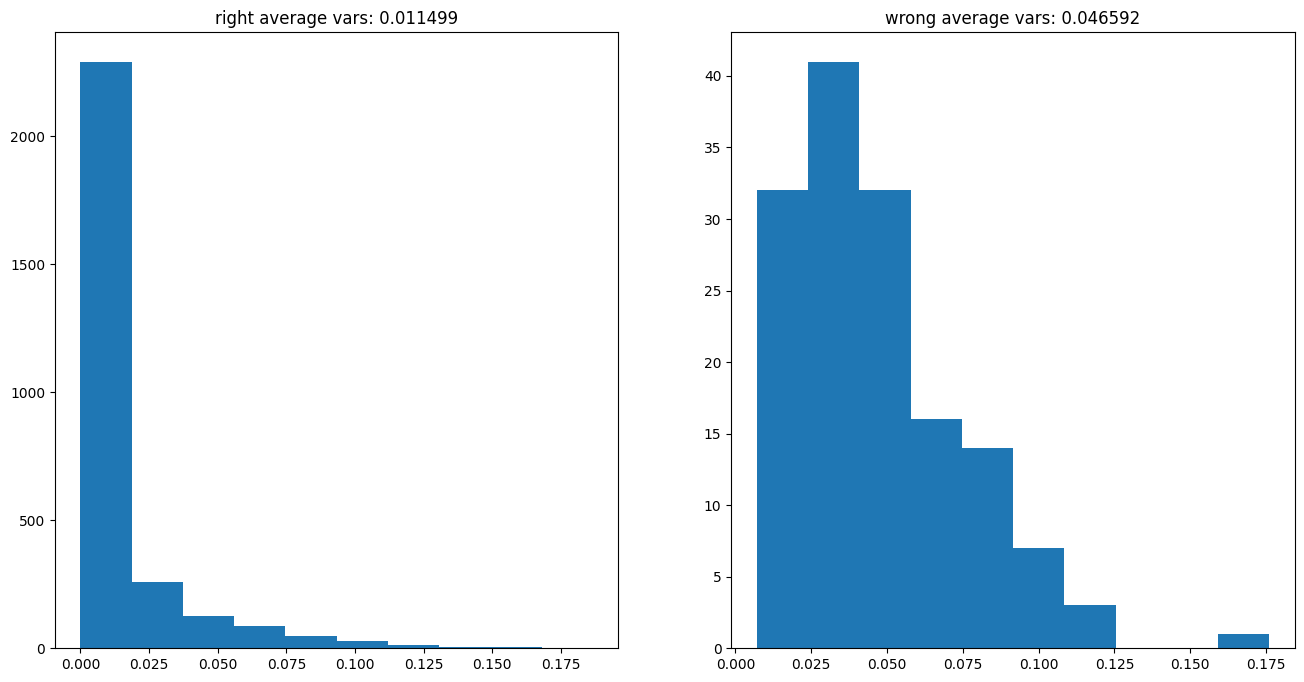

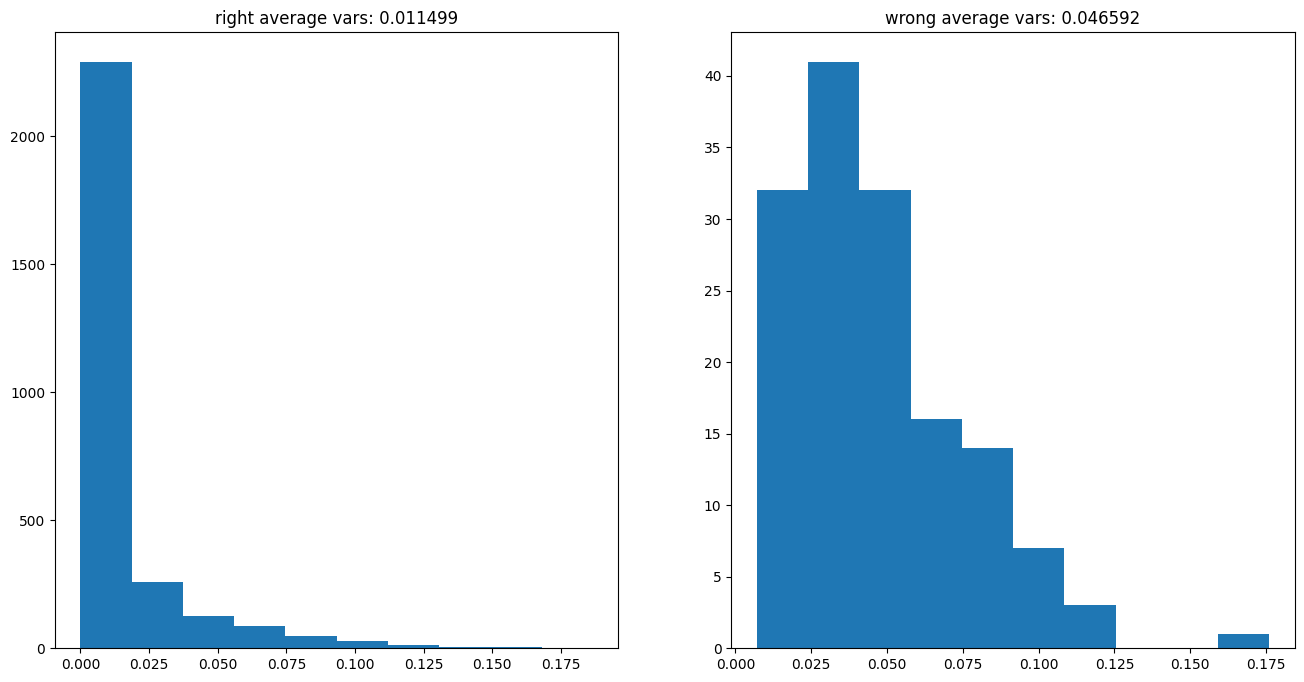

In [15]:
%matplotlib inline
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.hist(right_vars)
plt.title("right average vars: {:.6f}".format(np.mean(right_vars)))

plt.subplot(122)
plt.hist(wrong_vars)
plt.title("wrong average vars: {:.6f}".format(np.mean(wrong_vars)))

plt.show()

In [16]:
from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(right_vars, wrong_vars, method="auto")
p

2.22218103032247e-57

In [17]:
wrong_outs = []
wrong_var = []
lbs = []

for i in range(len(mean_list)):
    if mean_list[i].round().int() != labels[i].int():
        # print(mean_list[i], var_list[i], labels[i])

        wrong_outs.append(mean_list[i])
        wrong_var.append(var_list[i])
        lbs.append(labels[i])

wrong_outs = torch.tensor(wrong_outs)
wrong_var = torch.tensor(wrong_var)
lbs = torch.tensor(lbs)

sum(F.relu(wrong_outs - torch.sqrt(wrong_var)*2).round() == lbs) / len(lbs)

tensor(0.3219)

In [22]:
from sklearn.metrics import confusion_matrix

lbs_new = []

for i in range(len(wrong_outs)):
    if wrong_vars[i]<0.02:
        tmp = wrong_outs[i].round().item()
    else:
        if wrong_outs[i]>0.5:
            tmp = max((wrong_outs[i] - torch.sqrt(wrong_var[i])*3).round().item(), 0)
        else:
            # tmp = max((wrong_outs[i] - torch.sqrt(wrong_var[i])*2).item(), 1)
            # tmp = 1 - wrong_outs[i].round().item()
            tmp = min((wrong_outs[i] + torch.sqrt(wrong_var[i])*3).round().item(), 1)

    lbs_new.append(tmp)
# print(lbs_new)
lbs_new = torch.tensor(lbs_new).int()
print("rectified acc for wrong: {}".format(sum(lbs_new == lbs) / len(lbs)))
tn, fp, fn, tp = confusion_matrix(y_true=lbs.round(), y_pred=lbs_new).ravel()
tn, fp, fn, tp

rectified acc for wrong: 0.8630136847496033


(44, 6, 14, 82)

In [33]:
beta1 = 2 #1 #2 #3 #4
beta2 = 10*beta1

In [52]:
# x = np.linspace(0, 1, 1000)
# y = np.exp(beta2*x) / (1+np.exp(beta2*x))

# plt.plot(x, y)

p_yes = 0.5#1
p_no = 0.5#9

Q_yes = 0.5 #0.8
Q_no = 0.5 #0.2

p_A1_yes = p_yes * np.exp(beta1 * Q_yes) / (p_yes*np.exp(beta1*Q_yes) + p_no*np.exp(beta1*Q_no))
p_A1_no =  p_no*np.exp(beta1*Q_no) / (p_yes*np.exp(beta1*Q_yes) + p_no*np.exp(beta1*Q_no))

p_A1_yes, p_A1_no

(0.5, 0.5)

In [53]:
import gc
gc.collect()

17393

In [48]:
p_yes2yes = np.exp(beta2 * (Q_yes - Q_yes)) / (1 + np.exp(beta2 * (Q_yes - Q_yes)))
p_yes2no = np.exp(beta2 * (Q_no - Q_yes)) / (1 + np.exp(beta2 * (Q_no - Q_yes)))
p_no2yes = np.exp(beta2 * (Q_yes - Q_no)) / (1 + np.exp(beta2 * (Q_yes - Q_no)))
p_no2no = np.exp(beta2 * (Q_no - Q_no)) / (1 + np.exp(beta2 * (Q_no - Q_no)))

p_yes2yes, p_yes2no, p_no2yes, p_no2no

(0.5, 6.144174602214707e-06, 0.9999938558253978, 0.5)

In [54]:
(1 - np.exp(0.5) / (1 + np.exp(0.5))) * p_A1_yes

0.1887703343990727

In [49]:
p_A2_no_yes = (1 - p_no2yes) * p_A1_no
p_A2_no_yes

1.4222241462657687e-06

In [ ]:
x = np.linspace(0, 1, 1000)
y = np.exp(beta2*x) / (1+np.exp(beta2*x))

plt.plot(x, y)

In [49]:
# def calc_reward(pred_p, prior=[0.5,0.5], beta1=2, beta2=20):
#     p_A1 = [prior[i]*np.exp(beta1(prior[i])) / (prior[0]*np.exp(beta1(prior[0])) + prior[1]*np.exp(beta1(prior[1]))) for i in prior]
#     print(p_A1)

#     p_a_to_ap = 0.5

    

Q_hat = {"yes":torch.tensor([0.7]), "no":torch.tensor([0.3])}
prior = torch.tensor([0.5, 0.5])
beta1 = 2
beta2 = beta1 * 10



def p_A1(p, Q_hat, a="yes", beta1=2):

    up = p[a] * torch.exp(beta1 * Q_hat[a])

    down = 0
    for i in ["yes", "no"]:
        down += p[i] * torch.exp(beta1 * Q_hat[i])

    return up / down

# p_A1(p=Q_hat, Q_hat=Q_hat, a="yes", beta1=2)      # 0.8385
# p_A1(p=Q_hat, Q_hat=Q_hat, a="no", beta1=2)       # 0.1615



def p_trans(start, end, Q_hat, beta2):
    tmp = torch.exp(beta2 * (Q_hat[end] - Q_hat[start]))

    return tmp / (1+tmp)

# p_trans(start="yes", end="no", Q_hat=Q_hat)   # 0.0003
# p_trans(start="no", end="yes", Q_hat=Q_hat)   # 0.9997



def p_A2(a, a_prime, Q_hat, beta1, beta2):
    if a != a_prime:
        res = (1 - p_trans(start=a, end=a_prime, Q_hat=Q_hat, beta2=beta2)) * p_A1(p=Q_hat, Q_hat=Q_hat, a=a, beta1=beta1)

    if a == a_prime:
        t1 = (1 - p_trans(start=a_prime, end=a_prime, Q_hat=Q_hat, beta2=beta2)) * p_A1(p=Q_hat, Q_hat=Q_hat, a=a, beta1=beta1)

        t2 = 0
        for ai in ["yes", "no"]:
            t2 += p_trans(start=ai, end=a_prime, Q_hat=Q_hat, beta2=beta2) * p_A1(p=Q_hat, Q_hat=Q_hat, a=ai, beta1=beta1)

        res = t1 + t2

    return res

# p_A2(a="yes", a_prime="no", Q_hat=Q_hat)
# p_A2(a="no", a_prime="yes", Q_hat=Q_hat, beta1=beta1, beta2=beta2)
p_A2(a="yes", a_prime="no", Q_hat=Q_hat, beta1=beta1, beta2=beta2)
# p_A2(a="yes", a_prime="yes", Q_hat=Q_hat, beta1=beta1, beta2=beta2)
# p_A2(a="no", a_prime="no", Q_hat=Q_hat, beta1=beta1, beta2=beta2)

tensor([0.1618])